## Статистические критерии с помощью Python


Мы будем использовать набор данных, собранный `Gapminder Foundation` 

https://github.com/VasilisaS/product_star_mentoring/blob/main/gapminder.csv

Для работы с ними их можно скачать по ссылке выше в папку6 где лежит ваш Python-ноутбук

Набор данных `Gapminder` содержит набор переменных, используемых для оценки общего 
состояния здоровья и благополучия населения в странах по всему миру. 

In [1]:
# импорт необходимых модулей

import statsmodels.formula.api as smf
import statsmodels.stats.multicomp as multi
import scipy
from scipy.stats import pearsonr
import pandas as pd
from seaborn import regplot
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# чтение данных
df = pd.read_csv("gapminder.csv") 
df.head()

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,oilperperson,polityscore,relectricperperson,suicideper100th,employrate,urbanrate
0,Afghanistan,,.03,.5696534,26.8,75944000,25.6000003814697,,3.65412162280064,48.673,,0,,6.68438529968262,55.7000007629394,24.04
1,Albania,1914.99655094922,7.29,1.0247361,57.4,223747333.333333,42.0999984741211,,44.9899469578783,76.918,,9,636.341383366604,7.69932985305786,51.4000015258789,46.72
2,Algeria,2231.99333515006,.69,2.306817,23.5,2932108666.66667,31.7000007629394,.1,12.5000733055148,73.131,.42009452521537,2,590.509814347428,4.8487696647644,50.5,65.22
3,Andorra,21943.3398976022,10.17,,,,,,81,,,,,5.36217880249023,,88.92
4,Angola,1381.00426770244,5.57,1.4613288,23.1,248358000,69.4000015258789,2,9.99995388324075,51.093,,-2,172.999227388199,14.5546770095825,75.6999969482422,56.7


In [2]:
# создадим несколько дополнительных функций для обработки пропущенных значений

# функция проверяет пропущенные значения
def check_missing_values(df, cols): 
    for col in cols: 
        print("Column {} is missing:".format(col)) 
        print((df[col].values == ' ').sum()) 
        print() 
        
# функция ковертирует значения в числовые
def convert_numeric(dataframe, cols): 
    for col in cols: 
        dataframe[col] = pd.to_numeric(dataframe[col], 
                                       errors='coerce') 

In [3]:
print("Есть ли пропущенные значения? ", df.isnull().values.any())
print()

cols = ['lifeexpectancy', 'breastcancerper100th', 'suicideper100th',
        'internetuserate', 'employrate']

df2 = df.copy()

check_missing_values(df, cols)

convert_numeric(df2, cols)

Есть ли пропущенные значения?  False

Column lifeexpectancy is missing:
22

Column breastcancerper100th is missing:
40

Column suicideper100th is missing:
22

Column internetuserate is missing:
21

Column employrate is missing:
35



### Проанализируем взаимосвязь между:

    уровнем использования Интернета (internetuserate) и уровнем занятости населения (employrate) 


Сделаем графики для отношения уровня `использования Интернета (internetuserate)` и уровня `занятости населения (employrate) ` с помощью **Seaborn** и **Matplotlib**.

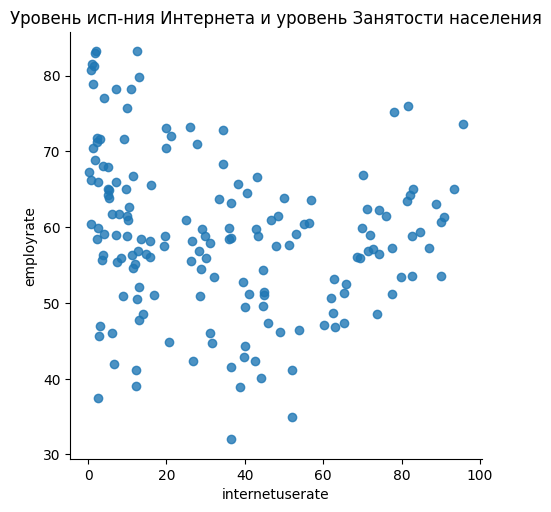

In [8]:
sns.lmplot(x="internetuserate",# УКАЖИТЕ название нужного столбца, 
           y="employrate",# УКАЖИТЕ название нужного столбца, 
           data=df2, 
           fit_reg=False)
plt.title("Уровень исп-ния Интернета и уровень Занятости населения")
plt.show()

График несколько напоминает __параболу__ (укажите функцию, на которую больше похоже текущее распределение)

----

## Формулируем гипотезы

**Нулевая гипотеза** – это гипотеза об отсутствии различий. В данном случае - об отсутсвии взаимосвязи между уровнем использования интернета и уровнем занятости населения.

Это то, что мы хотим опровергнуть. Обозначается как **Но**.


Cоответственно, **альтернативная гипотеза H1** в том, что взаимосвязь между уровнем использования интернета и продолжительностью жизни существует 

----

## Выбор критерия

Проверим гипотезы с помощью критерия __Хи-квадрат__

Критерий независимости Хи-квадрат - это непараметрический стат  критерий, используемый для анализа, насколько значима связь между двумя __категориальными__ переменными.

----

## Обработка данных

Для проверки гипотоез нас интересуют данные двух столбцов `"internetuserate"` и `"employrate"`. Они представляют собой вещественные переменные.

Для использования Хи-квадрат критерия нам нужно сделать обе переменные __категориальными__. 

Для этого разделим данные из обоих столбцов по __корзинкам__ так, что в кажду корзинку попадает одинаковое число объектов. Особенность разбиения в том, что данные упорядочены, и в каждую корзинку попадают достаточно близкие по значениям объекты

In [9]:
# функция для разбиения данных на 10 корзинок

def bin(dataframe, cols):
    for col in cols:
        new_col_name = "{}_bins".format(col)
        dataframe[new_col_name] = pd.qcut(dataframe[col], 
                                          10, 
                                          labels=["1=10%", "2=20%", "3=30%", "4=40%", 
                                                  "5=50%", "6=60%", "7=70%", "8=80%", 
                                                  "9=90%", "10=100%"])
        
# создаем копию датасета и делаем все изменения в копии
df3 = df2.copy()

# применяем функцию разбиения данных на 10 частей 
# для столбца Уровня занятости employrate
column = ['employrate']  # УКАЖИТЕ название нужного столбца в квадратных скобках
bin(df3, column)

In [10]:
# в результате - появился новый столбец в конце
# с разбиением средней продолжительности жизни на 10 корзинок
df3.head()

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,oilperperson,polityscore,relectricperperson,suicideper100th,employrate,urbanrate,employrate_bins
0,Afghanistan,,.03,.5696534,26.8,75944000,25.6000003814697,,3.654122,48.673,,0,,6.684385,55.700001,24.04,4=40%
1,Albania,1914.99655094922,7.29,1.0247361,57.4,223747333.333333,42.0999984741211,,44.989947,76.918,,9,636.341383366604,7.699330,51.400002,46.72,3=30%
2,Algeria,2231.99333515006,.69,2.306817,23.5,2932108666.66667,31.7000007629394,.1,12.500073,73.131,.42009452521537,2,590.509814347428,4.848770,50.500000,65.22,3=30%
3,Andorra,21943.3398976022,10.17,,NaN,,,,81.000000,NaN,,,,5.362179,NaN,88.92,NaN
4,Angola,1381.00426770244,5.57,1.4613288,23.1,248358000,69.4000015258789,2,9.999954,51.093,,-2,172.999227388199,14.554677,75.699997,56.7,10=100%


In [11]:
# функция для разбиения данных об уровне использования интерента
# на 2 корзинки

def half_bin(dataframe, cols):
    for col in cols:
        new_col_name = "{}_bins_2".format(col)
        dataframe[new_col_name] = pd.qcut(dataframe[col], 2, labels=["1=50%", "2=100%"])

half_bin(df3, ['internetuserate'])

In [12]:
# в результате - появился еще один столбец в конце 
# с разбиением уровня пользования интернетом на 2 корзинки
df3.head()

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,oilperperson,polityscore,relectricperperson,suicideper100th,employrate,urbanrate,employrate_bins,internetuserate_bins_2
0,Afghanistan,,.03,.5696534,26.8,75944000,25.6000003814697,,3.654122,48.673,,0,,6.684385,55.700001,24.04,4=40%,1=50%
1,Albania,1914.99655094922,7.29,1.0247361,57.4,223747333.333333,42.0999984741211,,44.989947,76.918,,9,636.341383366604,7.699330,51.400002,46.72,3=30%,2=100%
2,Algeria,2231.99333515006,.69,2.306817,23.5,2932108666.66667,31.7000007629394,.1,12.500073,73.131,.42009452521537,2,590.509814347428,4.848770,50.500000,65.22,3=30%,1=50%
3,Andorra,21943.3398976022,10.17,,NaN,,,,81.000000,NaN,,,,5.362179,NaN,88.92,NaN,2=100%
4,Angola,1381.00426770244,5.57,1.4613288,23.1,248358000,69.4000015258789,2,9.999954,51.093,,-2,172.999227388199,14.554677,75.699997,56.7,10=100%,1=50%


Выполнение теста Хи-квадрат включает в себя сначала построение __таблицы сопряженности__. 

Таблица сопряженности показывает частоту объясняемой переменной для различных уровней объясняющей переменной.

In [13]:
count_table = pd.crosstab(df3['internetuserate_bins_2'], 
                          df3['employrate_bins'])
print(count_table)
# каждая ячейка на персечении столбца и строки содержит 
# число объектов, попадающее в обе корзинки

employrate_bins         1=10%  2=20%  3=30%  4=40%  5=50%  6=60%  7=70%  \
internetuserate_bins_2                                                    
1=50%                       6      7      5     11      9      8      6   
2=100%                      9      9     14      3      9     10     11   

employrate_bins         8=80%  9=90%  10=100%  
internetuserate_bins_2                         
1=50%                       8     14       14  
2=100%                      7      4        3  


Теперь вычислим таблицы сопряженности для различных пар корзинок столбца `employrate`

Сейчас у нас 10 корзинок, а нам нужно сделать сравнение лишь для 2 из них 

In [15]:
# Создадим словари для различных пар корзинок продолжительности жизни
recode_3_7 = {"3=30%": "3=30%", "7=70%": "7=70%"}  # сравниваем корзинки 3 и 7
recode_2_8 = {"2=20%": "2=20%", "8=80%": "8=80%"} # ДОБАВЬТЕ код для сравнения корзинок 2 и 8  
recode_6_9 = {"6=60%": "6=60%", "9=90%": "9=90%"} # ДОБАВЬТЕ код для сравнения корзинок 6 и 9 
recode_4_7 = {"4=40%": "4=40%", "7=70%": "7=70%"} # ДОБАВЬТЕ код для сравнения корзинок 4 и }

# Создадим столбцы, которые будут хранить только соответствующие категории
# а остальные значения - убирать. 
    
df3['Comp_3v7'] = df3['employrate_bins'].map(recode_3_7)
df3['Comp_2v8'] = df3['employrate_bins'].map(recode_2_8)
df3['Comp_6v9'] = df3['employrate_bins'].map(recode_6_9)
df3['Comp_4v7'] = df3['employrate_bins'].map(recode_4_7)


In [16]:
# проверьте, что в конце таблицы у вас появились новые три столбца
# 'Comp_3v7', 'Comp_2v8' и 'Comp_6v9'
df3.head()

,country,incomeperperson,alcconsumption,armedforcesrate,breastcancerper100th,co2emissions,femaleemployrate,hivrate,internetuserate,lifeexpectancy,...,relectricperperson,suicideper100th,employrate,urbanrate,employrate_bins,internetuserate_bins_2,Comp_3v7,Comp_2v8,Comp_6v9,Comp_4v7
0,Afghanistan,,.03,.5696534,26.8,75944000,25.6000003814697,,3.654122,48.673,...,,6.684385,55.700001,24.04,4=40%,1=50%,NaN,NaN,NaN,4=40%
1,Albania,1914.99655094922,7.29,1.0247361,57.4,223747333.333333,42.0999984741211,,44.989947,76.918,...,636.341383366604,7.699330,51.400002,46.72,3=30%,2=100%,3=30%,NaN,NaN,NaN
2,Algeria,2231.99333515006,.69,2.306817,23.5,2932108666.66667,31.7000007629394,.1,12.500073,73.131,...,590.509814347428,4.848770,50.500000,65.22,3=30%,1=50%,3=30%,NaN,NaN,NaN
3,Andorra,21943.3398976022,10.17,,NaN,,,,81.000000,NaN,...,,5.362179,NaN,88.92,NaN,2=100%,NaN,NaN,NaN,NaN
4,Angola,1381.00426770244,5.57,1.4613288,23.1,248358000,69.4000015258789,2,9.999954,51.093,...,172.999227388199,14.554677,75.699997,56.7,10=100%,1=50%,NaN,NaN,NaN,NaN


In [17]:
# составим таблицы сопряженности на основе нужных столбцов

count_table_3_7 = pd.crosstab(df3['internetuserate_bins_2'], df3['Comp_3v7'])
count_table_2_8 = pd.crosstab(df3['internetuserate_bins_2'], df3['Comp_2v8'])    
count_table_6_9 = pd.crosstab(df3['internetuserate_bins_2'], df3['Comp_6v9'])                                
count_table_4_7 = pd.crosstab(df3['internetuserate_bins_2'], df3['Comp_4v7'])
                                
                                
# выведем информацию, которая содержится в таблицах сопряженности
                                
print('Таблица сопряженности для корзинок 3 и 7')
print(str(count_table_3_7))
                                
print('Таблица сопряженности для корзинок 2 и 8')
print(str(count_table_2_8))
                                
print('Таблица сопряженности для корзинок 6 и 9')
print(str(count_table_6_9))
                                                                                    
print('Таблица сопряженности для корзинок 4 и 7')
print(str(count_table_4_7))

Таблица сопряженности для корзинок 3 и 7
Comp_3v7                3=30%  7=70%
internetuserate_bins_2              
1=50%                       5      6
2=100%                     14     11
Таблица сопряженности для корзинок 2 и 8
Comp_2v8                2=20%  8=80%
internetuserate_bins_2              
1=50%                       7      8
2=100%                      9      7
Таблица сопряженности для корзинок 6 и 9
Comp_6v9                6=60%  9=90%
internetuserate_bins_2              
1=50%                       8     14
2=100%                     10      4
Таблица сопряженности для корзинок 4 и 7
Comp_4v7                4=40%  7=70%
internetuserate_bins_2              
1=50%                      11      6
2=100%                      3     11


Для такой таблицы сопряженности применим критерий __хи-квадрат__ на связь между уровнем использования интернета и уровнем занятости населения для этих двух групп.

Или точнее - то между уровнем пользования интренетом и занятости на уровне __20-30%__ и __60-70%__ 

(если говорить про первую пару корзинок 3 и 7)

In [18]:
# создадим функцию, которая будет возвращать 
# значение критерия хи-квадрат

def chi_sq_test(table):

    print("Рассматривает такую таблицу сопряженности:\n")

    # Вместо количества объектов в ячейках
    # вычислим долю объектов в этой группе среди остальных
    col_sum = table.sum(axis=0)
    col_percents = table/col_sum
    print(col_percents)
    print()
    
    chi_square, p, a, b = scipy.stats.chi2_contingency(table)
    print('P_value = ', p)
    
    if p > 0.05:
        print('Не отвергаем Ho, cтатистически значимых отличий нет')
    else:
        print('Не принимаем Ho, cтатистически значимые отличия есть')

    

In [19]:
# сравним группы 3 и 7
chi_sq_test(count_table_3_7)

Рассматривает такую таблицу сопряженности:

Comp_3v7                   3=30%     7=70%
internetuserate_bins_2                    
1=50%                   0.263158  0.352941
2=100%                  0.736842  0.647059

P_value =  0.8247418090950073
Не отвергаем Ho, cтатистически значимых отличий нет


In [20]:
# сравним группы 2 и 8
chi_sq_test(count_table_2_8)

Рассматривает такую таблицу сопряженности:

Comp_2v8                 2=20%     8=80%
internetuserate_bins_2                  
1=50%                   0.4375  0.533333
2=100%                  0.5625  0.466667

P_value =  0.8618712493148953
Не отвергаем Ho, cтатистически значимых отличий нет


In [21]:
# сравним группы 6 и 9
chi_sq_test(count_table_6_9)

Рассматривает такую таблицу сопряженности:

Comp_6v9                   6=60%     9=90%
internetuserate_bins_2                    
1=50%                   0.444444  0.777778
2=100%                  0.555556  0.222222

P_value =  0.0873752803407674
Не отвергаем Ho, cтатистически значимых отличий нет


In [22]:
# сравним группы 4 и 7
chi_sq_test(count_table_4_7)

Рассматривает такую таблицу сопряженности:

Comp_4v7                   4=40%     7=70%
internetuserate_bins_2                    
1=50%                   0.785714  0.352941
2=100%                  0.214286  0.647059

P_value =  0.04066081494394274
Не принимаем Ho, cтатистически значимые отличия есть
